Используем данные Apple

In [177]:
import copy
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from dateutil.relativedelta import relativedelta

# Source: https://www.statsmodels.org/stable/install.html
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Source: https://scikit-learn.org/stable/install.html
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [178]:
df = pd.read_csv("./HistoricalQuotes.csv")
df.head()

,Date,Close/Last,Volume,Open,High,Low
0,02/28/2020,$273.36,106721200,$257.26,$278.41,$256.37
1,02/27/2020,$273.52,80151380,$281.1,$286,$272.96
2,02/26/2020,$292.65,49678430,$286.53,$297.88,$286.5
3,02/25/2020,$288.08,57668360,$300.95,$302.53,$286.13
4,02/24/2020,$298.18,55548830,$297.26,$304.18,$289.23


In [179]:
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2518 entries, 0 to 2517
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         2518 non-null   datetime64[ns]
 1    Close/Last  2518 non-null   object        
 2    Volume      2518 non-null   int64         
 3    Open        2518 non-null   object        
 4    High        2518 non-null   object        
 5    Low         2518 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 78.8+ KB


In [180]:
df.axes

[RangeIndex(start=0, stop=2518, step=1),
 Index(['Date', ' Close/Last', ' Volume', ' Open', ' High', ' Low'], dtype='object')]

In [181]:
df = df.drop([' Close/Last', ' Volume', ' Open', ' Low'], axis=1)
df.head()

,Date,High
0,2020-02-28,$278.41
1,2020-02-27,$286
2,2020-02-26,$297.88
3,2020-02-25,$302.53
4,2020-02-24,$304.18


In [182]:
df[' High']

0         $278.41
1            $286
2         $297.88
3         $302.53
4         $304.18
          ...    
2513     $31.3857
2514     $30.1314
2515     $29.9814
2516     $30.1186
2517     $29.9286
Name:  High, Length: 2518, dtype: object

In [183]:
df['High'] = df[' High'].apply(lambda x: float(x[x.find('$') + 1:]))
# df.drop(' High')

In [184]:
def add_in_new_df(df, year, month, high_price):
  return df.append({'Date': datetime.date(year, month, 1), 'High': high_price}, ignore_index=True)

In [185]:
df_by_months = pd.DataFrame(columns=['Date', 'High'])
last = -1
h = -1

for index, row in df.iterrows():
    month = row['Date'].month
    h = max(h, row['High'])
    if last == -1:
        last = row['Date']
    if month != last.month:
        df_by_months = add_in_new_df(df_by_months, last.year, last.month, h)
        last = row['Date']
        h = -1
df = add_in_new_df(df_by_months, last.year, last.month, h)
df.head(10)

,Date,High
0,2020-02-01,327.22
1,2020-01-01,327.85
2,2019-12-01,293.97
3,2019-11-01,268.00
4,2019-10-01,249.75
5,2019-09-01,226.42
6,2019-08-01,221.37
7,2019-07-01,210.64
8,2019-06-01,201.57
9,2019-05-01,215.31


In [186]:
# Сделаем дату индексом для датасета
df.reset_index(inplace=True)
df = df.set_index(['Date'])
df.sort_index(inplace= True)
df.tail()

,index,High
Date,,
2019-10-01,4,249.75
2019-11-01,3,268.00
2019-12-01,2,293.97
2020-01-01,1,327.85
2020-02-01,0,327.22


In [187]:
df.to_csv("./df_processed.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 120 entries, 2010-03-01 to 2020-02-01
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   120 non-null    int64  
 1   High    120 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 2.3+ KB


<AxesSubplot:title={'center':'Apple stock'}, xlabel='Date', ylabel='High price, $'>

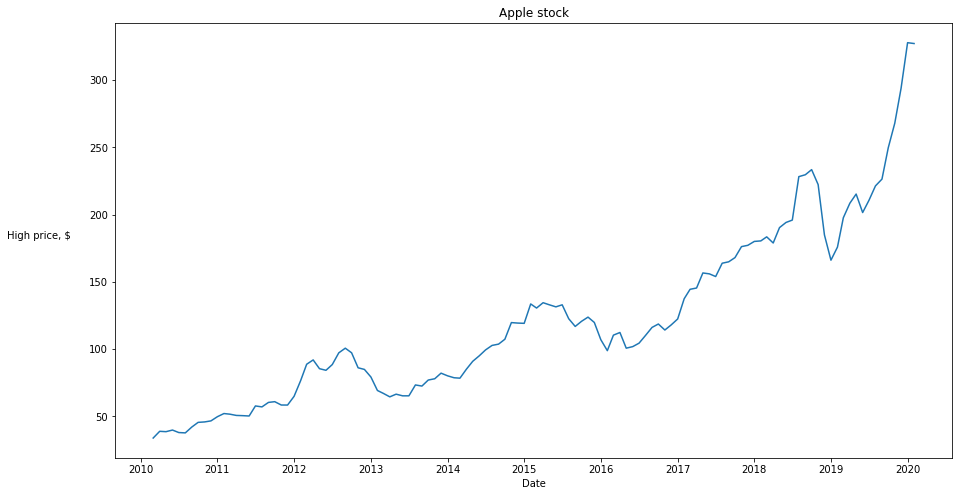

In [188]:
plt.figure(figsize=(15, 8))
plt.title('Apple stock')
plt.ylabel('High price, $', rotation=0, labelpad=50)
df['High'].plot()

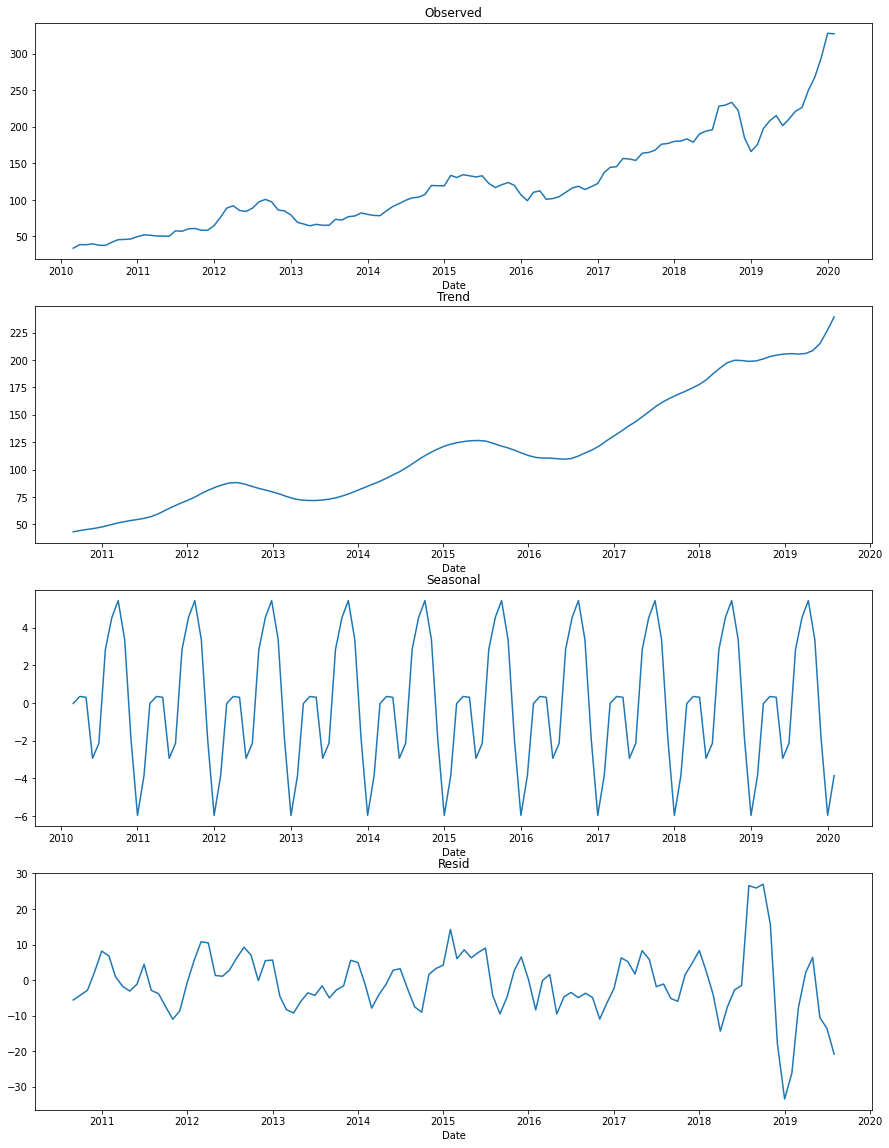

In [189]:
plt.figure(figsize=(15, 20))
decomposition = seasonal_decompose(df['High'], period=12)

ax = plt.subplot(411)
plt.title('Observed')
decomposition.observed.plot(ax=ax)

ax = plt.subplot(412)
plt.title('Trend')
decomposition.trend.plot(ax=ax)

ax = plt.subplot(413)
plt.title('Seasonal')
decomposition.seasonal.plot(ax=ax)

ax = plt.subplot(414)
plt.title('Resid')
decomposition.resid.plot(ax=ax);

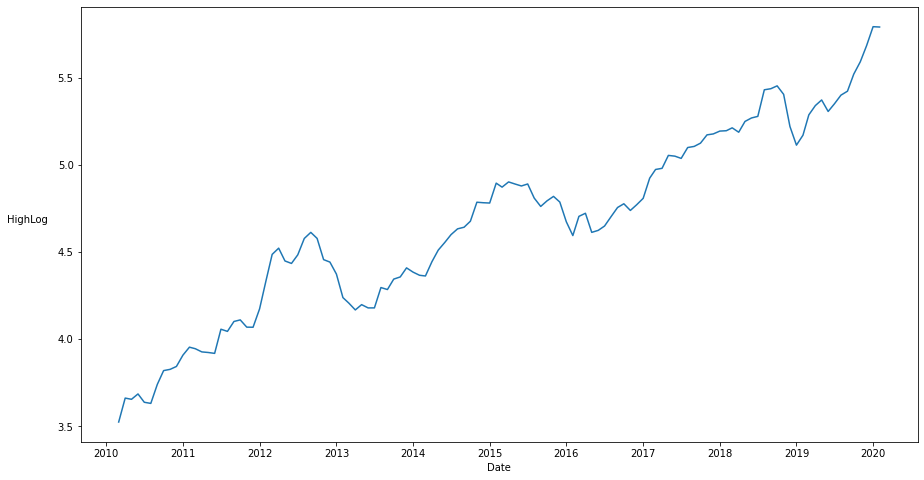

In [190]:
df['HighLog'] = np.log(df['High'])
plt.figure(figsize=(15, 8))
plt.ylabel('HighLog', rotation=0, labelpad=30)
df['HighLog'].plot();

Полученный уровень значимости (p-value): 0.0379. 0.0379 < 0.05. Нулевая гипотеза отвергается в пользу альтернативной!


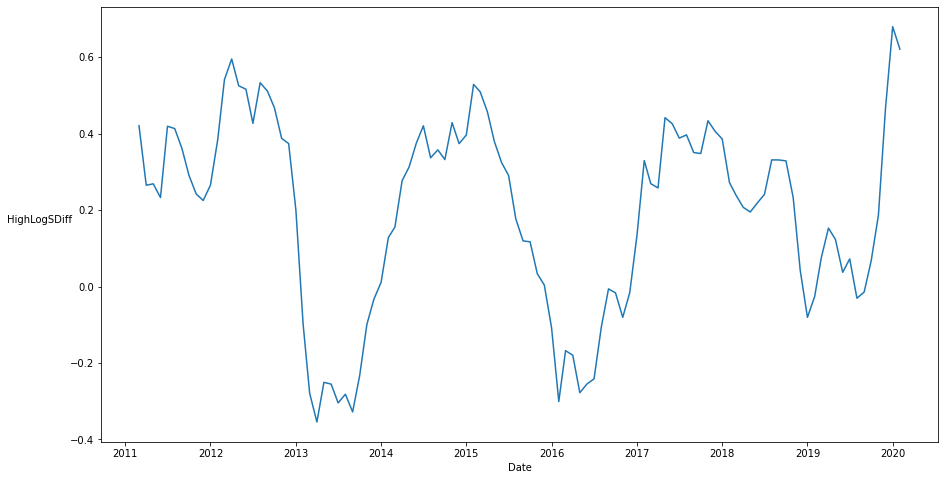

In [191]:
df['HighLogSDiff'] = df['HighLog'] - df['HighLog'].shift(12)
p_value = adfuller(df["HighLogSDiff"][12:])[1] 

print(
    f'Полученный уровень значимости (p-value): {round(p_value, 4)}.',
    f'{round(p_value, 4)} < 0.05. Нулевая гипотеза отвергается в пользу альтернативной!'
)

plt.figure(figsize=(15, 8))
plt.ylabel('HighLogSDiff', rotation=0, labelpad=30)
df['HighLogSDiff'].plot();

In [192]:
# df['HighLogSDiffODiff'] = df['HighLogSDiff'] - df['HighLogSDiff'].shift(1)
# p_value = adfuller(df["HighLogSDiffODiff"][13:])[1]

# print(
#     f'Полученный уровень значимости (p-value): {round(p_value, 4)}.',
#     f'{round(p_value, 4)} < 0.05. Нулевая гипотеза отвергается в пользу альтернативной!'
# )

# plt.figure(figsize=(15, 8))
# plt.ylabel('HighLogSDiffODiff', rotation=0, labelpad=30)
# df['HighLogSDiffODiff'].plot();


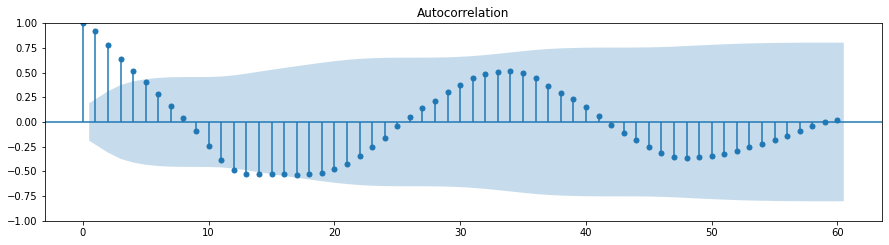

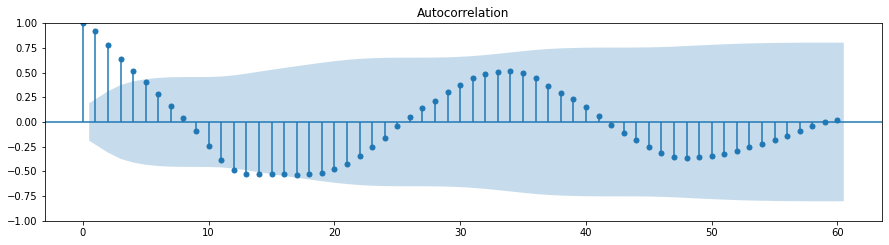

In [193]:

plt.figure(figsize=(15,8))

ax = plt.subplot(211)
statsmodels.graphics.tsaplots.plot_acf(df['HighLogSDiff'][13:], lags=60, ax=ax)


Сделаем прогнозирование

In [194]:
d=1
D=1

qs = range(1, 5)
Qs = range(1, 3)

ps = range(1, 5)
Ps = range(3, 5)

In [195]:
from itertools import product
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

64

In [197]:
%%time
#warnings.filterwarnings('ignore')
import statsmodels.api as sm


results = []
best_aic = float("inf")
train_len = int(len(df['HighLogSDiff']) * 0.8)

for param in tqdm(parameters_list):
    try:
        model = sm.tsa.statespace.SARIMAX(
            df['HighLogSDiff'][:train_len],
            order=(param[0], d, param[1]),
            seasonal_order=(param[2], D, param[3], 12)
        ).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

  0%|          | 0/64 [00:00<?, ?it/s]C:\Users\brodyaga\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\brodyaga\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\brodyaga\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  2%|▏         | 1/64 [00:06<06:26,  6.13s/it]C:\Users\brodyaga\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will 

Wall time: 10min 54s


In [198]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters        aic
0   (1, 1, 3, 1)  70.628884
2   (1, 1, 4, 1)  71.840728
1   (1, 1, 3, 2)  72.465548
16  (2, 1, 3, 1)  72.584978
4   (1, 2, 3, 1)  72.585750


In [199]:
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                       HighLogSDiff   No. Observations:                   96
Model:             SARIMAX(1, 1, 1)x(3, 1, 1, 12)   Log Likelihood                 -28.314
Date:                            Tue, 14 Dec 2021   AIC                             70.629
Time:                                    14:32:46   BIC                             87.561
Sample:                                03-01-2010   HQIC                            77.431
                                     - 02-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0172      0.455     -0.038      0.970      -0.909       0.875
ma.L1          0.3538      0.414   

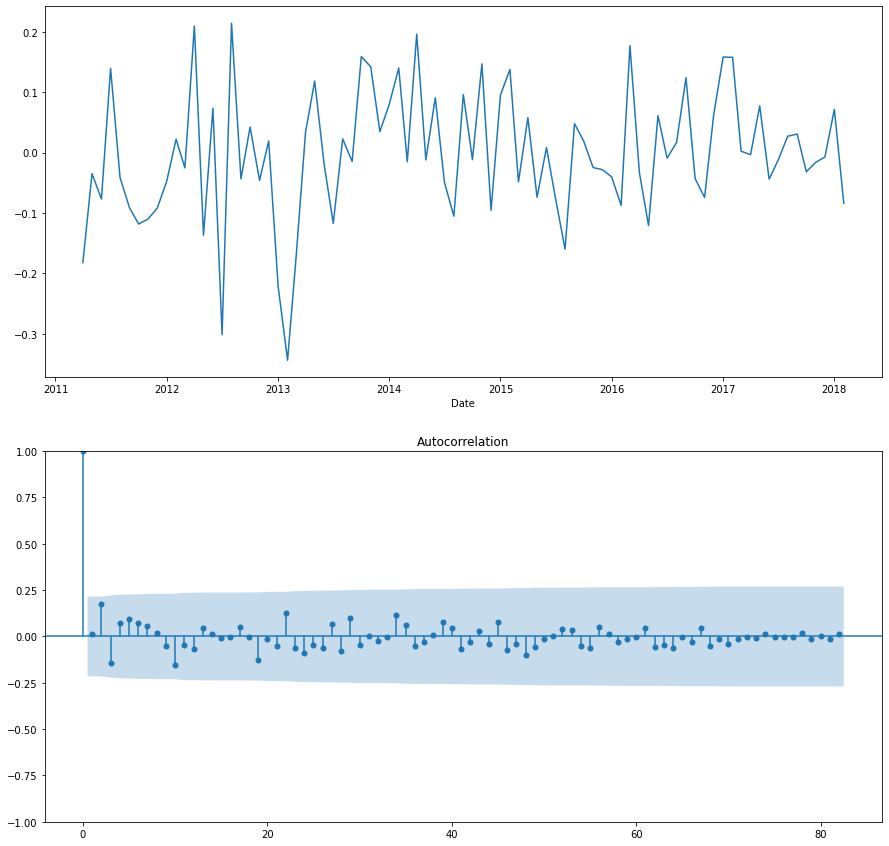

In [201]:
plt.figure(figsize=(15,15))

plt.subplot(211)
best_model.resid[13:].plot()

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=82, ax=ax);

<AxesSubplot:xlabel='Date'>

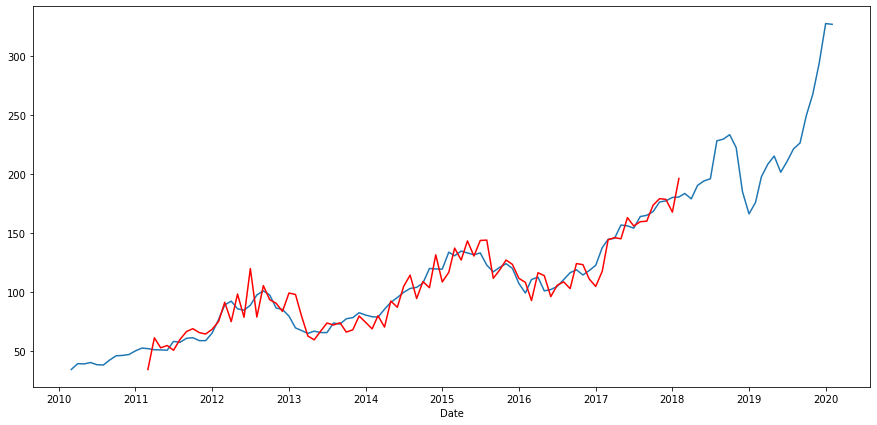

In [203]:
def original(x):
    return np.exp(x + df['HighLog'].shift(12))

df['Model'] = original(best_model.fittedvalues)

plt.figure(figsize=(15,7))

df['High'].plot()
df['Model'].plot(c='r')

In [204]:
df['High'][:train_len].tail()

Date
2017-10-01    168.07
2017-11-01    176.24
2017-12-01    177.20
2018-01-01    180.10
2018-02-01    180.48
Name: High, dtype: float64

In [239]:
new_close_value = df[['High', 'Model']]
future_date = [
    datetime.datetime.strptime("2018-03-01", "%Y-%m-%d") + relativedelta(months=x)
    for x in range(0, 120 - train_len)
]

future_df = pd.DataFrame(index=future_date, columns=['High', 'Model'])
new_close_value = pd.concat([new_close_value, future_df])

print(new_close_value.shape)
new_close_value.tail()

(144, 2)


,High,Model
2019-10-01 00:00:00,NaN,NaN
2019-11-01 00:00:00,NaN,NaN
2019-12-01 00:00:00,NaN,NaN
2020-01-01 00:00:00,NaN,NaN
2020-02-01 00:00:00,NaN,NaN


                     High       Model
2019-10-01 00:00:00   NaN  245.616186
2019-11-01 00:00:00   NaN  227.495959
2019-12-01 00:00:00   NaN  190.265899
2020-01-01 00:00:00   NaN  170.452773
2020-02-01 00:00:00   NaN  179.541853


C:\Users\brodyaga\AppData\Roaming\Python\Python38\site-packages\pandas\core\indexes\base.py:1963: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  return self._engine.is_monotonic_increasing
C:\Users\brodyaga\AppData\Roaming\Python\Python38\site-packages\pandas\core\sorting.py:403: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  indexer = non_nan_idx[non_nans.argsort(kind=kind)]


<AxesSubplot:xlabel='Date'>

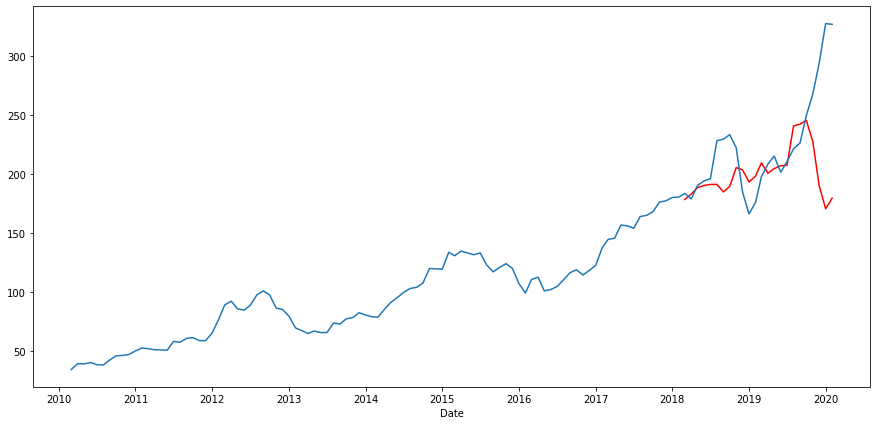

In [240]:
new_close_value['Model'] = original(best_model.predict(start=train_len, end=120))
print(new_close_value.tail())


plt.figure(figsize=(15,7))
new_close_value['Model'].plot(c='r')
df['High'].plot()

In [228]:
df['High'][train_len:]

Date
2018-03-01    183.5000
2018-04-01    178.9365
2018-05-01    190.3700
2018-06-01    194.2000
2018-07-01    195.9600
2018-08-01    228.2600
2018-09-01    229.6700
2018-10-01    233.4700
2018-11-01    222.3600
2018-12-01    184.9400
2019-01-01    166.1500
2019-02-01    175.8700
2019-03-01    197.6900
2019-04-01    208.4800
2019-05-01    215.3100
2019-06-01    201.5700
2019-07-01    210.6400
2019-08-01    221.3700
2019-09-01    226.4200
2019-10-01    249.7500
2019-11-01    268.0000
2019-12-01    293.9700
2020-01-01    327.8500
2020-02-01    327.2200
Name: High, dtype: float64

In [241]:
new_close_value['Model'][-(120-train_len):]

2018-03-01 00:00:00    178.414145
2018-04-01 00:00:00    183.094174
2018-05-01 00:00:00    188.462347
2018-06-01 00:00:00    190.344914
2018-07-01 00:00:00    191.136001
2018-08-01 00:00:00    191.223514
2018-09-01 00:00:00    184.802492
2018-10-01 00:00:00    189.451817
2018-11-01 00:00:00    205.488927
2018-12-01 00:00:00    203.626179
2019-01-01 00:00:00    193.310227
2019-02-01 00:00:00    198.232422
2019-03-01 00:00:00    209.464376
2019-04-01 00:00:00    200.680949
2019-05-01 00:00:00    204.663909
2019-06-01 00:00:00    207.053484
2019-07-01 00:00:00    207.443647
2019-08-01 00:00:00    240.831075
2019-09-01 00:00:00    242.401690
2019-10-01 00:00:00    245.616186
2019-11-01 00:00:00    227.495959
2019-12-01 00:00:00    190.265899
2020-01-01 00:00:00    170.452773
2020-02-01 00:00:00    179.541853
Name: Model, dtype: float64

In [242]:
from sklearn.metrics import mean_absolute_percentage_error

print(mean_absolute_percentage_error(df['High'][train_len:], new_close_value['Model'][-(120-train_len):]))

0.12159464749710058
